### This file is used for visualizing the results of causal history analysis in the stream chemistry analysis

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import copy
import numpy as np

# from tigramite_src import tigramite_plotting

# from utils import load_cit_data, load_cit_data3, load_net, plot_info, plot_citvmi, plot_info_general, filter_neighbor
from utils import load_cit_data3, load_net, filter_neighbor
from info.utils import tigramite_plotting
from info.utils.causal_network import causal_network
from info.utils.sst import conditionalIndependence, independence, independenceSet, conditionalIndependenceSet
from info.core.info import info, computeCMIKNN, computeMIKNN, computeEntropyKNN
from info.core.info_network import info_network
from info.utils.others import reorganize_data, dropna, normalize
import info.utils.tigramite_plotting as tp

The CUDA-KNN is not installed!.


In [2]:
# Plot settings
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colorbar import Colorbar
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
%matplotlib inline
rc('text', usetex=True)
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30

# plt.rc('text', usetex=True)              # usage of tex
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

### Parameters

In [3]:
# File Parameters
start, prtype = 0, 0
np.set_printoptions(precision=2)

In [7]:
# Plotting parameters
def get_filenames(folder, key):
    filename = folder + 'info_instream_new_' + key + '_taumax5.pkl'
    if 'transred' in key:
        key = key.replace('_transred', '')
        netfile  = folder + 'stream_cmiknn_parallel_instream_strict_' + key + '_taumax5_results.pkl'
        datasrc = 'parents_7hr_instream_strict_' + key + '_taumax5.pkl'
    else:
        netfile  = folder + 'stream_cmiknn_parallel_instream_strict_' + key + '_taumax5_results.pkl'
        datasrc = 'parents_7hr_instream_strict_' + key + '_taumax5.pkl'
    
    return netfile, filename, datasrc

def get_varnames(varnames):
    varnames2 = []
    for varn in varnames:
        if 'pH' in varn: varn2 = r'$pH$'
        elif 'alkalinity' in varn: varn2 = r'$ALK$'
        elif varn.startswith('fc'): varn2 = varn.split('_')[1]
        elif varn.startswith('log_flow'): varn2 = r'$\ln Q$'
        elif ' ' in varn: varn2 = varn.split()[0]
        varnames2.append(varn2)
    for i in range(len(varnames2)):
        if varnames2[i] == 'Na': varnames2[i] = r'$Na^{+}$'
        elif varnames2[i] == 'Cl': varnames2[i] = r'$Cl^{-}$'
        elif varnames2[i] == 'SO4': varnames2[i] = r'$SO4^{2-}$'
        elif varnames2[i] == 'Ca': varnames2[i] = r'$Ca^{2+}$'
        elif varnames2[i] == 'Al': varnames2[i] = r'$Al^{3+}$'
    return varnames2

def get_node_number_plot(nodedict, nvar, taumax):
    return taumax-abs(nodedict[1]) + (taumax+1)*abs(nodedict[0])

def get_title_labels(varnames):
    titles  = ['$-> ' + varn[1:-1] + '$' for varn in varnames]
    ylabels = ['$' + varn[1:-1] + '$ \n $[nats]$' for varn in varnames]
    return titles, ylabels

def reorder_data(data, order, index=[0]):
    if index == [0]:
        return data[order,:]
    elif index == [1]:
        return data[:,order]
    elif index == [0,1]:
        try:
            data2 = data[order,:,:]
            return data2[:,order,:]
        except:
            data2 = data[order,:]
            return data2[:,order]

# Parameters for the selected files
start, prtype = 0, 0
# folder, fig_folder = "./", "./"
folder = "/home/pjiang6/scripts/stream_analysis_Kirchner/tigramite/"
fig_folder = '/home/pjiang6/figures/stream_analysis/'

key1, key2 = '7var_raw_anomaly_transred', '6var_SO4_anomaly_transred'

# Parameters for plotting
labels = [r'$\mathcal{J}$', r'$\mathcal{D}$', r'$\mathcal{T}$','IND']
labels2 = [r'$\mathcal{J}$ dominated', r'$\mathcal{P}$ dominated']
# xlabel, ylabel = r'$\tau$ $[day]$', r'$[nats]$'
xlabel, ylabel = r'$\tau$', r'$[nats]$'
colors = ['blue', 'orange', 'black', 'red']
markers  = ['.', '.', '.', '.']
alphas = [1., 1., 1., 1]
figsize=(7,7)

# Parameters for network constructions
approach, k = 'knn', 5
taumax = 20

laganal = 10
taustart = 5

### Load the information-theoretic values

In [5]:
netfile1, filename1, datasrc1 = get_filenames(folder, key1)
netfile2, filename2, datasrc2 = get_filenames(folder, key2)

# Get the cit data
citset1, pitset1, titset1, pidcit1, pidpit1, sstpast1, taurange1, dimsize1, datasize1 = \
    load_cit_data3(filename1, datasrc1, prtype, start)
citset2, pitset2, titset2, pidcit2, pidpit2, sstpast2, taurange2, dimsize2, datasize2 = \
    load_cit_data3(filename2, datasrc2, prtype, start)

# Get the network
rd1, data1, net1, varnsraw1, lagfuncs1, sigthres1 = load_net(netfile1, folder+datasrc1, taumax, approach, k)
rd2, data2, net2, varnsraw2, lagfuncs2, sigthres2 = load_net(netfile2, folder+datasrc2, taumax, approach, k)

# Get the variable names and labels
varns1, varns2 = get_varnames(varnsraw1), get_varnames(varnsraw2)

# Get the order
varns2new = varns1[1:]
order = [varns2.index(varele) for varele in varns2new]
varns2 = varns2new

# Get the labels
nvar1, nvar2   = len(varns1), len(varns2)
titles1, ylabel1 = get_title_labels(varns1)
titles2, ylabel2 = get_title_labels(varns2)

# Reorder info metrics
lagfuncs2 = reorder_data(lagfuncs2, order, index=[0,1])
sigthres2 = reorder_data(sigthres2, order, index=[0,1])
citset2 = reorder_data(citset2, order, index=[0])
pitset2 = reorder_data(pitset2, order, index=[0])
titset2 = reorder_data(titset2, order, index=[0])

### Compute the momentary partial information decompsition from Al and SO4 to pH

The number of conditions from (3, -2) and (5, -2) to (6, 0) is 22, including:
[(0, -2), (2, -2), (6, -2), (0, -3), (2, -3), (3, -3), (4, -3), (5, -3), (6, -3), (2, -4), (3, -4), (4, -4), (6, -4), (0, -5), (2, -5), (4, -5), (5, -5), (2, -6), (5, -6), (6, -6), (1, -7), (5, -7)]


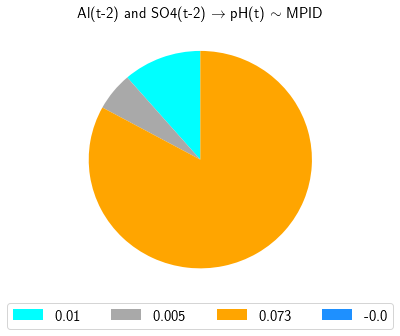

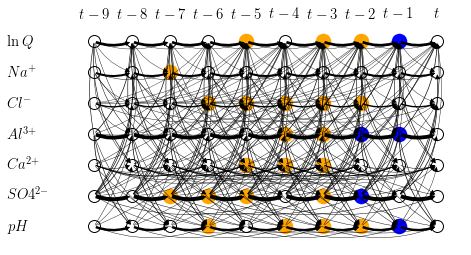

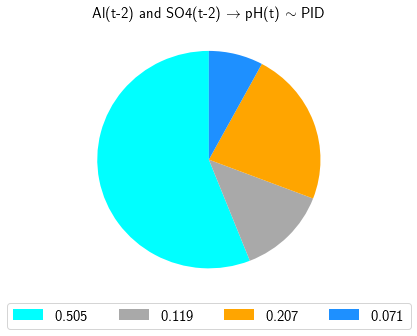

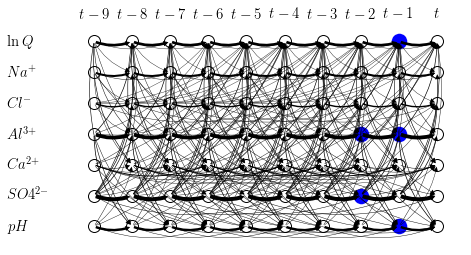

In [9]:
# The Al and Ca to pH
src1, src2, target = (3,-2), (5,-2), (6,0)
mpid1 = net1.compute_3n_infotrans(src1,src2,target)
pid1  = net1.compute_3n_infotrans(src1,src2,target,conditioned=False,verbosity=0)
s1, r1, uxz1, uyz1 = mpid1.s, mpid1.r,mpid1.uxz, mpid1.uyz
s2, r2, uxz2, uyz2 = pid1.s, pid1.r,pid1.uxz, pid1.uyz
# Plot the DAG graph
taumax2 = 9
w, cpaths = net1.network.search_mpid_condition(src1, src2, target,onlyw=False,verbosity=0)
wn = [get_node_number_plot(node, nvar1, taumax2) for node in w]
# Plot the PIE chart
sizes1 = np.around(np.array([uxz1, uyz1, s1, r1]), decimals=3)*100
sizes2 = np.around(np.array([uxz2, uyz2, s2, r2]), decimals=3)*100
colors = ['cyan', 'darkgrey', 'orange', 'dodgerblue']
# Plot
plt.figure(figsize=(5,5))
patches1, text1 = plt.pie(sizes1,labeldistance=1.1,colors=colors, shadow=False, startangle=90)
plt.legend(patches1, np.around(sizes1/100,decimals=3), ncol=4, loc="lower center", bbox_to_anchor=(.5,-.15), fontsize=15)
plt.title(r"Al(t-2) and SO4(t-2) $\rightarrow$ pH(t) $\sim$ MPID")
# plt.savefig(fig_folder + 'MPID_stream.eps', transparent=True, format='eps',bbox_inches='tight')
cpathsn = [get_node_number_plot(node, nvar1, taumax2) for node in cpaths]
fig = plt.figure(figsize=(7,4), frameon=False)
ax = fig.add_subplot(111, frameon=False)
tp.plot_time_series_graph2(
    fig=fig, ax=ax,
    lagfuncs=filter_neighbor(np.abs(lagfuncs1)),
    sig_thres=sigthres1,
    var_names=varns1,
    vmin_edges=0., vmax_edges=.08,
    edge_ticks=.02,
    label_fontsize=15,
    node_label_size=15,
    node_size=12,
    taumax=taumax2,
    highlighted_nodes=wn,
    highlighted_nodes2=cpathsn)
# plt.savefig(fig_folder + 'MPID_stream_DAG.eps', transparent=True, format='eps',bbox_inches='tight')
plt.figure(figsize=(5,5))
patches2, text2 = plt.pie(sizes2,labeldistance=1.1,colors=colors, shadow=False, startangle=90)
plt.legend(patches2, np.around(sizes2/100,decimals=3), ncol=4, loc="lower center", bbox_to_anchor=(.5,-.15), fontsize=15)
plt.title(r"Al(t-2) and SO4(t-2) $\rightarrow$ pH(t) $\sim$ PID");
# plt.savefig(fig_folder + 'PID_stream.eps', transparent=True, format='eps',bbox_inches='tight')
fig = plt.figure(figsize=(7,4), frameon=False)
ax = fig.add_subplot(111, frameon=False)
tp.plot_time_series_graph2(
    fig=fig, ax=ax,
    lagfuncs=filter_neighbor(np.abs(lagfuncs1)),
    sig_thres=sigthres1,
    var_names=varns1,
    vmin_edges=0., vmax_edges=.08,
    edge_ticks=.02,
    label_fontsize=15,
    node_label_size=15,
    node_size=12,
    taumax=taumax2,
    highlighted_nodes2=cpathsn)
# plt.savefig(fig_folder + 'PID_stream_DAG.eps', transparent=True, format='eps',bbox_inches='tight')

### Plot the information from the distant causal history ($\mathcal{D}$) and its percentage in the entire causal history ($\mathcal{D} / \mathcal{T}$)

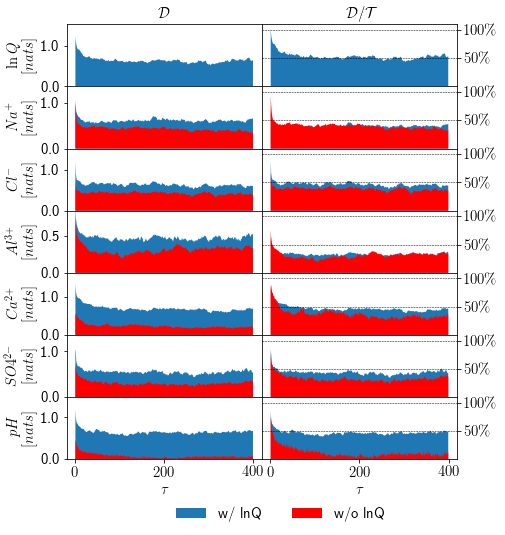

In [8]:
fig, axes = plt.subplots(nrows=nvar1,ncols=2,figsize=(7,8),sharex=True)

for i in range(nvar1):
    ax = axes[i,0]
    ax.fill_between(taurange1, np.zeros(taurange1.size), 
                    pitset1[i,:], label='w/ lnQ')
    ax.set_ylabel(ylabel1[i])
    infomean = np.array(pitset1[i,:]).mean()
    infomax = np.array(pitset1[i,:]).max()
    if infomax > 1:
        ax.set_ylim([0, max(1., infomax + 0.3)])
    else:
        ax.set_ylim([0, .6+infomean/2])
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

for i in range(nvar1):
    ax = axes[i,1]
    ax.fill_between(taurange1, np.zeros(taurange1.size), 
                    pitset1[i,:]/titset1[i,:], label='w/ lnQ')
    ax.set_ylim([0, 1.1])
    ax.set_yticks([0.5, 1.0])
    ax.set_yticklabels([r'$50\%$', r'$100\%$'])

    ax.axhline(y=1, linewidth=0.5, linestyle='--', c='k')
    ax.axhline(y=0.5, linewidth=0.5, linestyle='--', c='k')
    ax.yaxis.tick_right()
    ax.get_yaxis().set_label_coords(-0.1,0.5)

axes[0,0].set_title(r'$\mathcal{D}$')
axes[0,1].set_title(r'$\mathcal{D} / \mathcal{T}$')
axes[-1,0].set_xlabel(xlabel)
axes[-1,1].set_xlabel(xlabel)

for i in range(nvar2):
    ax = axes[i+1,0]
    ax.fill_between(taurange1, np.zeros(taurange1.size), pitset2[i,:], 
                    label='w/o lnQ', facecolor='red')

for i in range(nvar2):
    ax = axes[i+1,1]
#     ax.plot(taurange1, (titset2[i,:]-pitset2[i,:])/pitset2[i,:], label='w/o lnQ', color='red')
    ax.fill_between(taurange1, np.zeros(taurange1.size), pitset2[i,:]/titset2[i,:], 
                    label='w/o lnQ', facecolor='red')

ax.legend(ncol=2, bbox_to_anchor=(.7, -0.55), fontsize=15,frameon=False)
plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig(fig_folder + 'PITTIT_compare_' + key1 + '_vs_' + key2 + '.eps', 
#             transparent=True, format='eps',bbox_inches='tight')

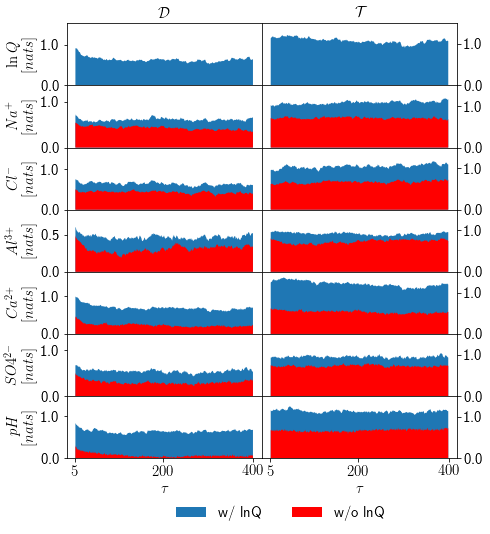

In [9]:
fig, axes = plt.subplots(nrows=nvar1,ncols=2,figsize=(7,8),sharex=True)

for i in range(nvar1):
    ax = axes[i,0]
    ax.fill_between(taurange1[taustart:], np.zeros(taurange1.size)[taustart:], 
                    pitset1[i,taustart:], label='w/ lnQ')
    ax.set_ylabel(ylabel1[i])
    infomean = np.array(pitset1[i,:]).mean()
    infomax = np.array(pitset1[i,:]).max()
    if infomax > 1:
        ax.set_ylim([0, max(1., infomax + 0.3)])
    else:
        ax.set_ylim([0, .6+infomean/2])
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xticks([5,200,400])

for i in range(nvar1):
    ax = axes[i,1]
    ax.fill_between(taurange1[taustart:], np.zeros(taurange1.size)[taustart:], 
                    citset1[i,taustart:]+pitset1[i,taustart:], label='w/ lnQ')
    ax.set_ylim([0, 1.5])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax.set_yticks([0.5, 1.0])
#     ax.set_yticklabels([r'$50\%$', r'$100\%$'])

#     ax.axhline(y=1, linewidth=0.5, linestyle='--', c='k')
#     ax.axhline(y=0.5, linewidth=0.5, linestyle='--', c='k')
    ax.yaxis.tick_right()
    ax.get_yaxis().set_label_coords(-0.1,0.5)

axes[0,0].set_title(r'$\mathcal{D}$')
axes[0,1].set_title(r'$\mathcal{T}$')
axes[-1,0].set_xlabel(xlabel)
axes[-1,1].set_xlabel(xlabel)

for i in range(nvar2):
    ax = axes[i+1,0]
    ax.fill_between(taurange1[taustart:], np.zeros(taurange1.size)[taustart:], 
                    pitset2[i,taustart:], alpha=1.,
                    label='w/o lnQ', facecolor='red')

for i in range(nvar2):
    ax = axes[i+1,1]
    ax.fill_between(taurange1[taustart:], np.zeros(taurange1.size)[taustart:], 
                    citset2[i,taustart:]+pitset2[i,taustart:], alpha=1., 
                    label='w/o lnQ', facecolor='red')

ax.legend(ncol=2, bbox_to_anchor=(.7, -0.55), fontsize=15,frameon=False)
plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig(fig_folder + 'PITTIT2_compare_' + key1 + '_vs_' + key2 + '.eps', 
#             transparent=True, format='eps',bbox_inches='tight')

### Plot the partial information decomposition from the entire causal history ($\mathcal{T}$)

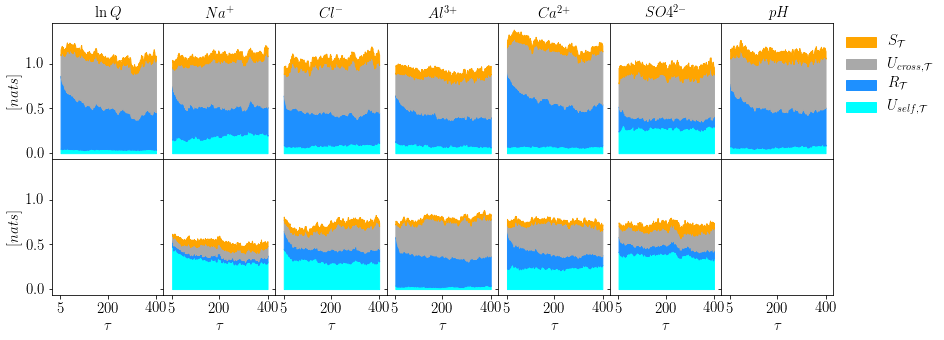

In [33]:
pidlabelst = ['$S_{\mathcal{T}}$', '$R_{\mathcal{T}}$', '$U_{self,\mathcal{T}}$', '$U_{cross,\mathcal{T}}$']
colors = ['orange', 'dodgerblue', 'cyan', 'darkgrey']
colors1 = ['yellow', 'lawngreen', 'violet', 'lightgrey']

fig, axes = plt.subplots(nrows=2,ncols=nvar1,figsize=(14,5),sharey=True,sharex=True)
for i in range(nvar1):
    ax = axes[0,i]
    base = np.zeros(taurange1.size)[taustart:]
    for j in [2,1,3,0]:
        ax.fill_between(taurange1[taustart:], base, base+pidcit1[i,taustart:,j]+pidpit1[i,taustart:,j],
                        color=colors[j], label=pidlabelst[j])
        base += pidcit1[i,taustart:,j]+pidpit1[i,taustart:,j]
for i in range(nvar2):
    ax = axes[1,i+1]
    base = np.zeros(taurange2.size)[taustart:]
    for j in [2,1,3,0]:
        ax.fill_between(taurange2[taustart:], base, base+pidcit2[i,taustart:,j]+pidpit2[i,taustart:,j], 
                        color=colors[j], label=pidlabelst[j])
        base += pidcit2[i,taustart:,j]+pidpit2[i,taustart:,j]
for i in range(nvar1):
    ax = axes[0,i]
    ax.set_title(varns1[i])
    axes[-1,i].set_xticks([5,200,400]) 
    axes[-1,i].set_xlim([-30,430])
    axes[-1,i].set_xlabel(xlabel)
for j in range(2):
    axes[j,0].set_ylabel(r'$[nats]$')
handles, labels = axes[0,-1].get_legend_handles_labels()
axes[0,-1].legend(handles[::-1], labels[::-1], ncol=1, bbox_to_anchor=(2., 1.), fontsize=15,frameon=False)
# axes[0,-1].legend(ncol=1, bbox_to_anchor=(2., 1.), fontsize=15,frameon=False)
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig(fig_folder + 'CHA_PIDTOTAL_compare_' + key1 + '_vs_' + key2 + '.eps', 
#             transparent=True, format='eps',bbox_inches='tight')

### Plot the partial information decomposition from the immediate  ($\mathcal{J}$) and distant  ($\mathcal{D}$) causal histories

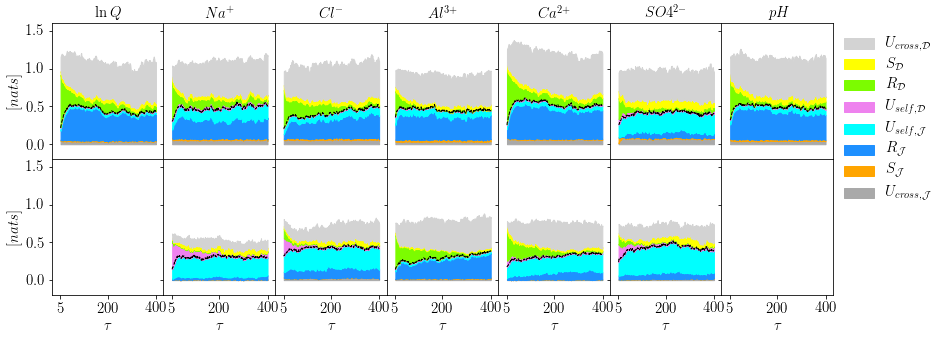

In [22]:
pidlabelsi = ['$S_{\mathcal{J}}$', '$R_{\mathcal{J}}$', '$U_{self,\mathcal{J}}$', '$U_{cross,\mathcal{J}}$']
pidlabelsd = ['$S_{\mathcal{D}}$', '$R_{\mathcal{D}}$', '$U_{self,\mathcal{D}}$', '$U_{cross,\mathcal{D}}$']
fig, axes = plt.subplots(nrows=2,ncols=nvar1,figsize=(14,5),sharey=True,sharex=True)
for i in range(nvar1):
    ax = axes[0,i]
    base = np.zeros(taurange1.size)[taustart:]
    for j in [3,0,1,2]:
        ax.fill_between(taurange1[taustart:], base, base+pidcit1[i,taustart:,j],
                        color=colors[j], label=pidlabelsi[j])
        base += pidcit1[i,taustart:,j]
    ax.plot(taurange1[taustart:], base, 'k--', linewidth=1)
    for j in [2,1,0,3]:
        ax.fill_between(taurange1[taustart:], base, base+pidpit1[i,taustart:,j],
                        color=colors1[j], label=pidlabelsd[j])
        base += pidpit1[i,taustart:,j]
for i in range(nvar2):
    ax = axes[1,i+1]
    base = np.zeros(taurange2.size)[taustart:]
    for j in [3,0,1,2]:
        ax.fill_between(taurange2[taustart:], base, base+pidcit2[i,taustart:,j], 
                        color=colors[j], label=pidlabelsi[j])
        base += pidcit2[i,taustart:,j]
    ax.plot(taurange2[taustart:], base, 'k--', linewidth=1)
    for j in [2,1,0,3]:
        ax.fill_between(taurange2[taustart:], base, base+pidpit2[i,taustart:,j], 
                        color=colors1[j], label=pidlabelsd[j])
        base += pidpit2[i,taustart:,j]
for i in range(nvar1):
    ax = axes[0,i]
    ax.set_title(varns1[i])
    axes[-1,i].set_xticks([5,200,400]) 
    axes[-1,i].set_xlim([-30,430])
    axes[-1,i].set_xlabel(xlabel)
    axes[-1,i].set_ylim([-0.2,1.6])
for j in range(2):
    axes[j,0].set_ylabel(r'$[nats]$')
handles, labels = axes[0,-1].get_legend_handles_labels()
axes[0,-1].legend(handles[::-1], labels[::-1], ncol=1, bbox_to_anchor=(2., 1.), fontsize=15,frameon=False)
plt.subplots_adjust(hspace=0, wspace=0)        
# plt.savefig(fig_folder + 'CHA_PIDCITPIT_compare_' + key1 + '_vs_' + key2 + '.eps', 
#             transparent=True, format='eps',bbox_inches='tight')

### Plot the results of significance test on distant  ($\mathcal{D}$) causal histories

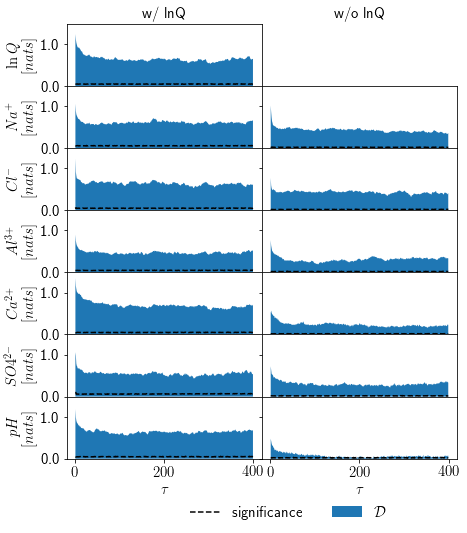

In [12]:
fig, axes = plt.subplots(nrows=nvar1,ncols=2,figsize=(7,8),sharex=True,sharey=True)

for i in range(nvar1):
    ax = axes[i,0]
    ax.fill_between(taurange1, np.zeros(taurange1.size), pitset1[i,:], label='$\mathcal{D}$')
    ax.plot(taurange1, sstpast1[i,:,2], 'k--', label='significance')
    ax.set_ylabel(ylabel1[i])
    infomean = np.array(pitset1[i,:]).mean()
    infomax = np.array(pitset1[i,:]).max()
    if infomax > 1:
        ax.set_ylim([0, max(1., infomax + 0.3)])
    else:
        ax.set_ylim([0, .6+infomean/2])
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[0,0].set_title('w/ lnQ')
axes[0,1].set_title('w/o lnQ')
axes[-1,0].set_xlabel(xlabel)
axes[-1,1].set_xlabel(xlabel)

for i in range(nvar2):
    ax = axes[i+1,1]
    ax.fill_between(taurange1, np.zeros(taurange1.size), pitset2[i,:], label='$\mathcal{D}$')
    ax.plot(taurange1, sstpast2[i,:,2], 'k--', label='significance')
        
axes[0,1].axis('off')

ax.legend(ncol=2, bbox_to_anchor=(.7, -0.55), fontsize=15,frameon=False)
plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig(fig_folder + 'PIT_significance_' + key1 + '_vs_' + key2 + '_log.eps', 
#             transparent=True, format='eps',bbox_inches='tight')

### Plot the number of datapoints

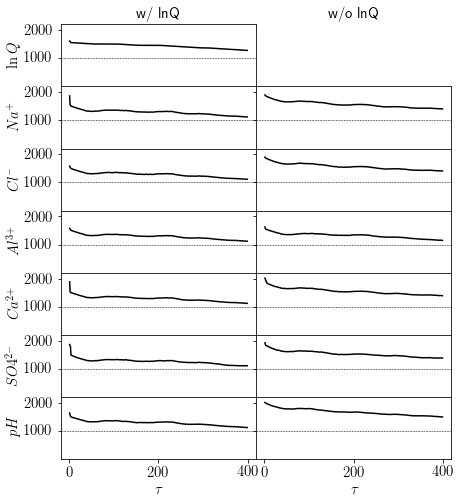

In [10]:
fig, axes = plt.subplots(nrows=nvar1,ncols=2,figsize=(7,8),sharex=True,sharey=True)

for i in range(nvar1):
    ax = axes[i,0]
    ax.plot(taurange1, datasize1[i,:,2], 'k', label='data size')
    ax.set_ylabel(varns1[i])
    ax.set_ylim([0, 2200])
    ax.set_yticks([1000,2000])
    ax.axhline(y=1000, linewidth=0.5, linestyle='--', c='k')

axes[0,0].set_title('w/ lnQ')
axes[0,1].set_title('w/o lnQ')
axes[-1,0].set_xlabel(xlabel)
axes[-1,1].set_xlabel(xlabel)

for i in range(nvar2):
    ax = axes[i+1,1]
    ax.plot(taurange1, datasize2[i,:,2], 'k', label='data size')
    ax.set_ylim([0, 2200])
    ax.set_yticks([1000,2000])
    ax.axhline(y=1000, linewidth=0.5, linestyle='--', c='k')
axes[0,1].axis('off')

plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig(fig_folder + 'PIT_datasize_' + key1 + '_vs_' + key2 + '.eps', 
#             transparent=True, format='eps',bbox_inches='tight')

### Plot the dimensions for $\mathcal{D}$, $\mathcal{J}$

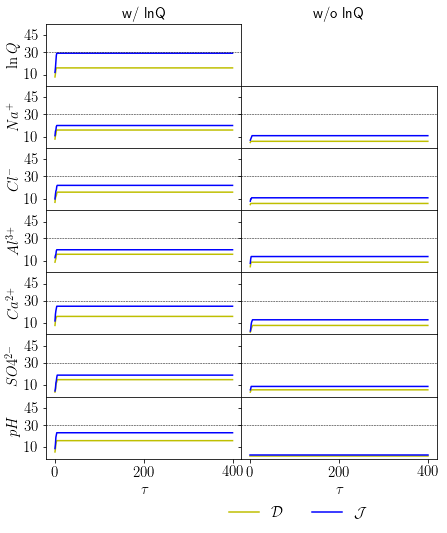

In [11]:
fig, axes = plt.subplots(nrows=nvar1,ncols=2,figsize=(7,8),sharex=True,sharey=True)

for i in range(nvar1):
    ax = axes[i,0]
    ax.plot(taurange1, dimsize1[i,:,2], 'y', label='$\mathcal{D}$')
    ax.plot(taurange1, dimsize1[i,:,1], 'b', label='$\mathcal{J}$')
    ax.set_ylabel(varns1[i])
    ax.set_ylim([0, 55])
    ax.set_yticks([10,30,45])
    ax.axhline(y=30, linewidth=0.5, linestyle='--', c='k')

axes[0,0].set_title('w/ lnQ')
axes[0,1].set_title('w/o lnQ')
axes[-1,0].set_xlabel(xlabel)
axes[-1,1].set_xlabel(xlabel)

for i in range(nvar2):
    ax = axes[i+1,1]
    ax.plot(taurange2, dimsize2[i,:,2], 'y', label='$\mathcal{D}$')
    ax.plot(taurange2, dimsize2[i,:,1], 'b', label='$\mathcal{J}$')
    ax.set_ylim([0, 55])
    ax.set_yticks([10,30,45])
    ax.axhline(y=30, linewidth=0.5, linestyle='--', c='k')
axes[0,1].axis('off')

plt.subplots_adjust(hspace=0, wspace=0)
ax.legend(ncol=2, bbox_to_anchor=(.7, -0.55), fontsize=15,frameon=False)

# plt.savefig(fig_folder + 'PIT_datasize_' + key1 + '_vs_' + key2 + '.eps', 
#             transparent=True, format='eps',bbox_inches='tight')